In [1]:
import sys
import os

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
# 親ディレクトリのパスを取得
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class Suite2pROICheckGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "SUITE2P_ROI_CHECK"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]
        self.app_key_pri = self.app_keys[0]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # FileLoadUI用のレイアウト
        self.layout_file_load = QVBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # メインUI用のレイアウト
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)
        # ファイル読み込み用のUIを追加
        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            self.setupMainUI()
        else:
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # メインUIのクリア
            clearLayout(self.layout_main_ui)
        
        # 新しいメインUIの設定
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    def loadData(self):
        success = loadFallMATWithGUI(
            q_window=self, 
            data_manager=self.data_manager, 
            key_app=self.app_key_pri, 
            path_fall=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_fall"].text()
        )
        if self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_reftif"].text() != "":
            self.data_manager.dict_im_bg_chan2[self.app_key_pri] = loadTIFImage(
                data_manager=self.data_manager, 
                key_dict_im_chan2=self.app_key_pri, 
                path_image=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_reftif"].text(), 
                preprocessing=True
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0)
        self.layout_main_ui.addLayout(self.makeLayoutSectionMiddleUpper(), 0, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 2)

    def setupControls(self):
        self.control_manager.table_controls[self.app_key_pri] = TableControl(
            key_app=self.app_key_pri,
            q_table=self.widget_manager.dict_table[self.app_key_pri],
            data_manager=self.data_manager,
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
        )
        
        self.control_manager.table_controls[self.app_key_pri].setupWidgetROITable(self.app_key_pri)
        self.control_manager.view_controls[self.app_key_pri] = ViewControl(
            key_app=self.app_key_pri,
            q_view=self.widget_manager.dict_view[self.app_key_pri], 
            q_scene=self.widget_manager.dict_scene[self.app_key_pri], 
            data_manager=self.data_manager, 
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
        )
        self.control_manager.view_controls[self.app_key_pri].setViewSize()
        self.control_manager.canvas_controls[self.app_key_pri] = CanvasControl(
            key_app=self.app_key_pri,
            figure=self.widget_manager.dict_figure[self.app_key_pri], 
            canvas=self.widget_manager.dict_canvas[self.app_key_pri], 
            data_manager=self.data_manager, 
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
            ax_layout="triple"
        )

    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    # ファイル読み込み用UI Layout
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()

        # LineEdit
        list_label = ["Fall mat file path", "Reference Tiff image file path (optional)"]
        list_key = [f"{self.app_key_pri}_path_fall", f"{self.app_key_pri}_path_reftif"]
        for label, key in zip(list_label, list_key):
            layout.addLayout(makeLayoutLoadFileWidget(
                self.widget_manager, 
                label=label, 
                key_label=key, 
                key_lineedit=key, 
                key_button=key
            ))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left Upper"
    def makeLayoutComponentPlotProperty(self):
        layout = QHBoxLayout()
        layout.addLayout(makeLayoutLightPlotMode(self.widget_manager, self.config_manager))
        layout.addLayout(makeLayoutMinimumPlotRange(self.widget_manager, self.config_manager, self.app_key_pri))
        return layout
    
    # EventFileの読み込み, plot用
    def makeLayoutComponentEventFilePlot(self):
        layout = makeLayoutEventFilePlot(self.widget_manager, self.app_key_pri)
        return layout
    
    "Middle Upper"
    # ROI view
    def makeLayoutComponentROIView(self):
        layout = QVBoxLayout()
        layout.addWidget(self.widget_manager.makeWidgetView(key=self.app_key_pri))
        return layout

    # ROI property label, threshold lineedit
    def makeLayoutComponentROIPropertyDisplay_Threshold(self):
        layout = QVBoxLayout()

        layout.addLayout(makeLayoutROIProperty(self.widget_manager, key_label=f"{self.app_key_pri}_roi_prop"))
        # layout.addLayout(makeLayoutROIThresholds(
        #     self.widget_manager, 
        #     key_label=f"{self.app_key_pri}_roi_threshold", 
        #     key_lineedit=f"{self.app_key_pri}_roi_threshold", 
        #     key_button=f"{self.app_key_pri}_roi_threshold", 
        #     label_button="Update ROI Display", 
        #     dict_roi_threshold=self.config_manager.gui_defaults["ROI_THRESHOLDS"],
        # ))
        return layout

    # ROI display, background image button group, checkbox
    def makeLayoutComponentROIDisplay_BGImageDisplay_ROISkip(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutDislplayCelltype(
            self, 
            self.widget_manager, 
            key_buttongroup=f'{self.app_key_pri}_display_celltype', 
            table_columns=self.config_manager.table_columns[self.app_key_pri].getColumns()
        ))
        layout.addLayout(makeLayoutBGImageTypeDisplay(
            self, 
            self.widget_manager, 
            key_buttongroup=f'{self.app_key_pri}_im_bg_type'
        ))
        layout.addLayout(makeLayoutROIChooseSkip(
            self.widget_manager, 
            key_checkbox=f'{self.app_key_pri}', 
            table_columns=self.config_manager.table_columns[self.app_key_pri].getColumns()
        ))
        return layout

    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{self.app_key_pri}_{channel}", 
                key_checkbox=f"{self.app_key_pri}_{channel}", 
                key_slider=f"{self.app_key_pri}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=self.app_key_pri, 
            key_slider=self.app_key_pri, 
            label=self.app_key_pri
        ))
        return layout

    "Right Upper"
    # Table, ROI count label, Table Columns Config, Set ROI Celltype, ROICheck IO
    def makeLayoutComponentTable_ROICountLabel_ROISetSameCelltype_ROICheckIO(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutTableROICountLabel(
            self.widget_manager, 
            key_label=self.app_key_pri, 
            key_table=self.app_key_pri, 
            table_columns=self.config_manager.table_columns[self.app_key_pri].getColumns()
        ))
        layout.addWidget(self.widget_manager.makeWidgetButton(key=f"{self.app_key_pri}_config_table", label="Table Columns Config"))
        layout.addLayout(makeLayoutAllROISetSameCelltype(
            self.widget_manager, 
            key_button=self.app_key_pri, 
            table_columns=self.config_manager.table_columns[self.app_key_pri].getColumns()
        ))
        layout.addLayout(makeLayoutAllROICheckboxToggle(
            self.widget_manager, 
            key_button=self.app_key_pri, 
            table_columns=self.config_manager.table_columns[self.app_key_pri].getColumns()
        ))
        layout.addLayout(makeLayoutROICheckIO(
            self.widget_manager, 
            key_button=self.app_key_pri
        ))
        return layout

    # ROI Filter, threshold
    def makeLayoutComponentROIFilter(self):
        layout = QHBoxLayout()
        layout.addLayout(makeLayoutROIFilterThreshold(
            self.widget_manager, 
            key_label=f"{self.app_key_pri}_roi_filter", 
            key_lineedit=f"{self.app_key_pri}_roi_filter",
            dict_roi_threshold=self.config_manager.gui_defaults["ROI_THRESHOLDS"]
        ))
        layout.addLayout(makeLayoutROIFilterButton(
            self.widget_manager, 
            key_label=f"{self.app_key_pri}_roi_filter", 
            key_button=f"{self.app_key_pri}_roi_filter"
        ))
        return layout
    

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 左上
    def makeLayoutSectionLeftUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutCanvasTracePlot(
            self.widget_manager, 
            key_figure=self.app_key_pri, 
            key_canvas=self.app_key_pri, 
            key_app=self.app_key_pri
        ), stretch=1)
        layout.addLayout(self.makeLayoutComponentPlotProperty())
        layout.addLayout(self.makeLayoutComponentEventFilePlot())
        return layout

    # 中上
    def makeLayoutSectionMiddleUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentROIView())
        layout.addLayout(self.makeLayoutComponentROIPropertyDisplay_Threshold())
        layout.addLayout(self.makeLayoutComponentROIDisplay_BGImageDisplay_ROISkip())
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider())
        return layout
    
    # 右上
    def makeLayoutSectionRightUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentTable_ROICountLabel_ROISetSameCelltype_ROICheckIO())
        layout.addLayout(self.makeLayoutComponentROIFilter())
        return layout

    # 下
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowTableColumnConfig(self, key_app):
        config_window = TableColumnConfigWindow(
            self, 
            self.control_manager.table_controls[key_app].table_columns, 
            self.config_manager.gui_defaults
        )
        if config_window.exec_():
            self.loadFilePathsandInitialize()
            

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):        
        list_key = [f"{self.app_key_pri}_path_fall", f"{self.app_key_pri}_path_reftif"]
        list_filetype = ["mat", "tiff"]
        for key, filetype in zip(list_key, list_filetype):
            bindFuncLoadFileWidget(
                q_widget=self, 
                q_button=self.widget_manager.dict_button[key], 
                q_lineedit=self.widget_manager.dict_lineedit[key], 
                filetype=filetype
            )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])

    def bindFuncAllWidget(self):
        # ROICheck save load
        bindFuncROICheckIO(
            q_window=self, 
            q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_fall"], 
            q_table=self.widget_manager.dict_table[f"{self.app_key_pri}"], 
            q_button_save=self.widget_manager.dict_button[f"{self.app_key_pri}_save_roicheck"], 
            q_button_load=self.widget_manager.dict_button[f"{self.app_key_pri}_load_roicheck"], 
            table_columns=self.config_manager.table_columns[self.app_key_pri].getColumns()
        )
        # Table Column Config
        self.widget_manager.dict_button[f"{self.app_key_pri}_config_table"].clicked.connect(
            lambda: self.showSubWindowTableColumnConfig(self.app_key_pri)
        )
        # Radiobutton BGImageType buttonChanged
        bindFuncRadiobuttonBGImageTypeChanged(
            q_buttongroup=self.widget_manager.dict_buttongroup[f"{self.app_key_pri}_im_bg_type"], 
            view_control=self.control_manager.view_controls[self.app_key_pri],
        )
        # Radiobutton ROIDisplayType buttonChanged
        bindFuncRadiobuttonDisplayCelltypeChanged(
            q_buttongroup=self.widget_manager.dict_buttongroup[f"{self.app_key_pri}_display_celltype"], 
            view_control=self.control_manager.view_controls[self.app_key_pri],
            table_control=self.control_manager.table_controls[self.app_key_pri],
        )
        # Set AllROI same celltype
        bindFuncButtonSetAllROISameCelltype(
            widget_manager=self.widget_manager,
            table_control=self.control_manager.table_controls[self.app_key_pri],
            view_control=self.control_manager.view_controls[self.app_key_pri],
        )
        # Toggle AllROI checkbox
        bindFuncButtonToggleAllROICheckbox(
            widget_manager=self.widget_manager,
            table_control=self.control_manager.table_controls[self.app_key_pri],
            view_control=self.control_manager.view_controls[self.app_key_pri],
        )
        # ROICheck Table onSelectionChanged
        bindFuncTableSelectionChanged(
            q_table=self.widget_manager.dict_table[self.app_key_pri],
            table_control=self.control_manager.table_controls[self.app_key_pri],
            view_control=self.control_manager.view_controls[self.app_key_pri],
            canvas_control=self.control_manager.canvas_controls[self.app_key_pri],
        )
        # ROICheck Table TableColumn CellType Changed
        bindFuncRadiobuttonOfTableChanged(
            table_control=self.control_manager.table_controls[self.app_key_pri],
            view_control=self.control_manager.view_controls[self.app_key_pri],
        )
        # Slider Opacity valueChanged
        bindFuncOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"{self.app_key_pri}_opacity_roi_all"],
            view_control=self.control_manager.view_controls[self.app_key_pri],
        )
        bindFuncHighlightOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"{self.app_key_pri}_opacity_roi_selected"],
            view_control=self.control_manager.view_controls[self.app_key_pri],
        )
        # Slider Contrast valueChanged, Checkbox show channel stateChanged
        for channel in self.config_manager.gui_defaults["CHANNELS"]:
            bindFuncBackgroundContrastSlider(
                q_slider_min=self.widget_manager.dict_slider[f"{self.app_key_pri}_{channel}_contrast_min"],
                q_slider_max=self.widget_manager.dict_slider[f"{self.app_key_pri}_{channel}_contrast_max"],
                view_control=self.control_manager.view_controls[self.app_key_pri],
                channel=channel
            )
            bindFuncBackgroundVisibilityCheckbox(
                q_checkbox=self.widget_manager.dict_checkbox[f"{self.app_key_pri}_{channel}_show"], 
                view_control=self.control_manager.view_controls[self.app_key_pri],
                channel=channel,
            )
        # View MousePressEvent
        bindFuncViewMouseEvent(
            q_view=self.widget_manager.dict_view[self.app_key_pri],
            view_control=self.control_manager.view_controls[self.app_key_pri],
            table_control=self.control_manager.table_controls[self.app_key_pri],
        )
        # Canvas MouseEvent
        # Top axis events
        canvas_control = self.control_manager.canvas_controls[self.app_key_pri]
        bindFuncCanvasMouseEvent(
            canvas_control.canvas,
            canvas_control,
            canvas_control.axes[AxisKeys.TOP],
            list_event=['scroll_event', 'button_press_event', 'button_release_event', 'motion_notify_event'],
            list_func=[canvas_control.onScroll, canvas_control.onPress, canvas_control.onRelease, canvas_control.onMotion]
        )
        # Middle axis events
        bindFuncCanvasMouseEvent(
            canvas_control.canvas,
            canvas_control,
            canvas_control.axes[AxisKeys.MID],
            list_event=['button_press_event'],
            list_func=[canvas_control.onClick]
        )
        # Canvas load EventFile
        bindFuncButtonEventfileIO(
            q_button_load=self.widget_manager.dict_button[f"{self.app_key_pri}_load_eventfile"],
            q_button_clear=self.widget_manager.dict_button[f"{self.app_key_pri}_clear_eventfile"],
            q_window=self,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            canvas_control=self.control_manager.canvas_controls[self.app_key_pri],
            key_app=self.app_key_pri,
        )


if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = Suite2pROICheckGUI()
    gui.show()
    sys.exit(app.exec_())

SystemExit: 0

c:\Users\HyperPC_Smee\anaconda3\envs\itkelastix\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
gui.widget_manager.dict_lineedit

{'pri_path_fall': <PyQt5.QtWidgets.QLineEdit at 0x15143ce38b0>,
 'pri_path_reftif': <PyQt5.QtWidgets.QLineEdit at 0x1516114c0d0>,
 'light_plot_mode_threshold': <PyQt5.QtWidgets.QLineEdit at 0x1516110c790>,
 'pri_plot_min_width': <PyQt5.QtWidgets.QLineEdit at 0x1516110c550>,
 'pri_plot_eventfile_range': <PyQt5.QtWidgets.QLineEdit at 0x1516110c280>,
 'pri_roi_threshold_npix': <PyQt5.QtWidgets.QLineEdit at 0x1514510adc0>,
 'pri_roi_threshold_compact': <PyQt5.QtWidgets.QLineEdit at 0x1514510af70>,
 'pri_roi_filter_npix': <PyQt5.QtWidgets.QLineEdit at 0x151450ff9d0>,
 'pri_roi_filter_radius': <PyQt5.QtWidgets.QLineEdit at 0x151450ffb80>,
 'pri_roi_filter_aspect_ratio': <PyQt5.QtWidgets.QLineEdit at 0x151450ffd30>,
 'pri_roi_filter_compact': <PyQt5.QtWidgets.QLineEdit at 0x151450ffee0>,
 'pri_roi_filter_skew': <PyQt5.QtWidgets.QLineEdit at 0x151450fb0d0>,
 'pri_roi_filter_std': <PyQt5.QtWidgets.QLineEdit at 0x151450fb280>}

In [3]:
np.mean(gui.control_manager.canvas_controls["pri"].trace_segments, axis=0).shape

(601,)

In [2]:
from optic.utils.data_utils import extractEventOnsetIndices, extractEventAlignedData
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path_eventfile = "..\data\EventFile_KA86_240227_053116_HfixHoloCS__ID_KA86-f1-z160_240227_1-preHolo\EventFile1D_RPsgFrameBase_StimDuration.npy"

eventfile = np.load(path_eventfile, allow_pickle=True)

In [5]:
event_indices = extractEventOnsetIndices(eventfile)

pre_frames, post_frames = 300, 900

event_segments = extractEventAlignedData(eventfile, event_indices, pre_frames, post_frames)

In [8]:
event_segments = np.array(event_segments)

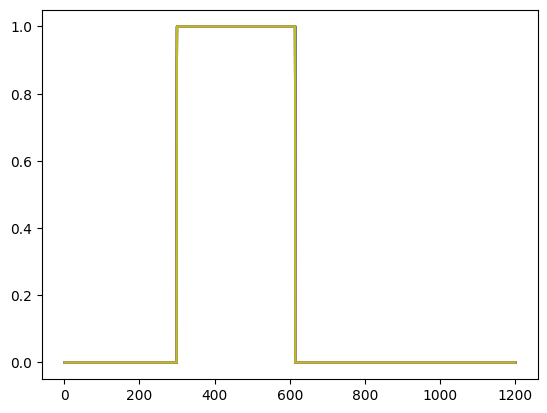

In [9]:
plt.figure()
for seg in event_segments:
    plt.plot(seg)
plt.show()